# Creating a dynamical system

Topics:
* What *is* a dynamical system, for **DynamicalSystems.jl**?
* How to define a discrete or continuous system.
* What is the different handling of large and small systems?
* Docstrings

# `DynamicalSystem`
The functions of **DynamicalSystems.jl** are centered around 2 data structures: 

1. Numerical data (`AbstractDataset` instance), shown in the previous tutorial
2. Dynamical systems (`DynamicalSystem` instance). This handles cases where one has *known equations of motion*.

For all intents and purposes, a `DynamicalSystem` is a Julia `struct` that contains all the information of a dynamical system. In short, it is simply a container of the following:
1. Equations of motion function $\vec{f}$ :  
    * $\frac{d\vec{u}}{dt} = \vec{f}(\vec{u}, t)$ for continuous, or
    * $\vec{u}_{n+1} = \vec{f}(\vec{u}_n, n)$ for discrete systems.
3. Initial condition.
4. Parameter container (if the equations of motion are parameterized).
2. Jacobian of the equations of motion.

# Creating a simple discrete system

We now want to define such a `DynamicalSystem`. The function call signature for making this is:
```julia
DiscreteDynamicalSystem(eom, state, p [, jacobian [, J0]]; t0::Int = 0)
ContinuousDynamicalSystem(eom, state, p [, jacobian [, J0]]; t0 = 0.0)
```

For starters, let's make a simple low-dimensional discrete chaotic system, the [Hénon map](https://en.wikipedia.org/wiki/H%C3%A9non_map). As it will be come apparent in the rest of the tutorial, there is no difference in the definition of a discrete or continuous system.

For simplicity let's also forget for now all these optional arguments like `jacobian, J0, t0`. The constructor we need is simply:

```julia
DiscreteDynamicalSystem(eom, state, p)
```

I will now explain step by step all arguments that must be given to the constructors, and what form they must have.

## Equations of motion
A **function** representing the equations of motion is the first argument of the above constructors: `eom`.

Therefore, the first step in creating a `DynamicalSystem` is to define the equations of motion. For the Hénon map they have the form:
$$
\begin{aligned}
x_{n+1} &= 1 - ax^2_n+y_n \\
y_{n+1} & = bx_n
\end{aligned}
$$

Now we must make a function out of them. There is some strictness when writing this function in Julia. Specifically, it can only be one of two forms: in-place (iip) or out-of-place (iip). Here is how to define it:

* **oop** : The `eom` function **must** be in the form `eom(x, p, t) -> SVector`
  which means that given a state `x::SVector` and some parameter container
  `p` it returns an [`SVector`](http://juliaarrays.github.io/StaticArrays.jl/stable/pages/api.html#SVector-1)
  (from the [StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl) module)
  containing the next state.
* **iip** : The `eom` function **must** be in the form `eom!(xnew, x, p, t)`
  which means that given a state `x::Vector` and some parameter container `p`,
  it writes in-place the new state in `xnew`.

We advise to use **oop** for systems with dimension < 11, and use **iip** otherwise.

Because the Hénon map only 2-dimensional, we follow the advice of the documentation and take advantage of [`StaticArrays`](https://github.com/JuliaArrays/StaticArrays.jl) module:

In [5]:
using StaticArrays
h_eom(x, p, t) = SVector{2}(1.0 - p[1]*x[1]^2 + x[2], p[2]*x[1])

h_eom (generic function with 1 method)

Remember: *both* `p` (for parameters) and `t` (for time) must be included in the equations of motion function, irrespectively of if they are used or not!

The second argument for the `DiscreteDynamicalSystem` constructor is a `state`, which represents the initial condition for the system:

In [7]:
state = zeros(2) # doesn't matter if we use Vector of SVector for the `state`

2-element Array{Float64,1}:
 0.0
 0.0

Then, the last argument, `p`, is simply a parameter container. It is advantageous to use a mutable container, to allow for changing parameters later:

In [3]:
p = [1.4, 0.3] # p = [a, b] from the equations

2-element Array{Float64,1}:
 1.4
 0.3

These 3 things are enough to make a `DynamicalSystem`:

In [6]:
using DynamicalSystems

henon = DiscreteDynamicalSystem(h_eom, state, p)

2-dimensional discrete dynamical system
 state:     [0.0, 0.0]
 e.o.m.:    h_eom
 in-place?  false
 jacobian:  ForwardDiff


The `show` function nicely summarized the dynamical system components (I'll talk about the `jacobian` later).

## Getting a trajectory

Now that we have created the system, the first (and most basic) thing to do is to simply plot its time evolution and see what it looks like. 

The `trajectory` function is a convenient tool that evolves the system and returns the output at equally spaced time intervals. The call signature is simply:

```julia
trajectory(ds::DynamicalSystem, T [, u]; kwargs...)
```
which evolves a system for total time `T`, optionally starting from a different state `u`.

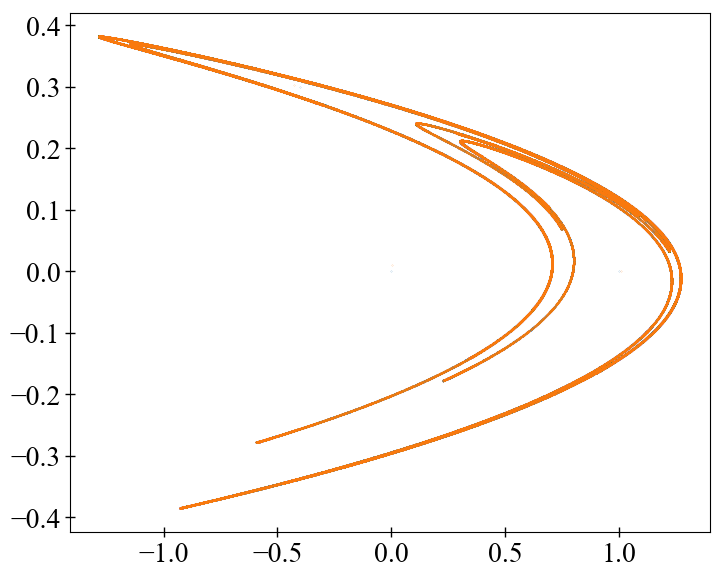

In [11]:
# trajectory with initial condition
tr = trajectory(henon, 100000)
# trajectory from a different starting point
tr2 = trajectory(henon, 100000, 0.01rand(2))

using PyPlot
figure(figsize=(8,6))
plot(tr[:, 1], tr[:, 2], lw = 0.0, marker = "o", ms = 0.1);
plot(tr2[:, 1], tr2[:, 2], lw = 0.0, marker = "o", ms = 0.1);

Because both starting points fall into an attractor, they cover each other.

# Adding a Jacobian

# I STOPPED HERE

The above system `henon` does not have a user-provided Jacobian function. Even though the automatic computation through `ForwardDiff` is extremely efficient, the best possible performance will come if you pass a "hard-coded" jacobian:

Now I'd like to focus on the last line describing the system, namely 

and notifies us that the module [`ForwardDiff`](http://www.juliadiff.org/ForwardDiff.jl/stable/user/api.html) was used to create a Jacobian function.

---

In [7]:
h_jacobian(x, p, n) = @SMatrix [-2*p[1]*x[1] 1.0; p[2] 0.0]

henon_with_jac = DiscreteDynamicalSystem(h_eom, zeros(2), [1.4, 0.3], h_jacobian)

2-dimensional discrete dynamical system
 state:     [0.0, 0.0]
 e.o.m.:    h_eom
 in-place?  false
 jacobian:  h_jacobian


To see the difference in performance, let's evolve the system and its tangent space (the function `tangent_integrator` will be discussed in the tutorial "Advanced Usage"):


In [8]:
t1 = tangent_integrator(henon, 2)
t2 = tangent_integrator(henon_with_jac, 2)
using BenchmarkTools
# Benchmark how much time does a single "step" take, i.e. evolving
# the system and tangent space for 1 discrete time step
@btime step!($t1)
@btime step!($t2)

  23.893 ns (0 allocations: 0 bytes)
  12.800 ns (0 allocations: 0 bytes)


You can see that even though `ForwardDiff` is truly performant, the hard-coded version is twice as fast.

# Continuous System
The process of creating a continuous system is fully identical to that of a discrete system, but the constructor `ContinuousDynamicalSystem` is used instead. We will take the opportunity to show the process of using in-place equations of motion for a continuous system, which is aimed to be used for large systems (dimensionality $\ge$ 10). In addition, the system we will use (Henon-Heiles) does not have any paramters.

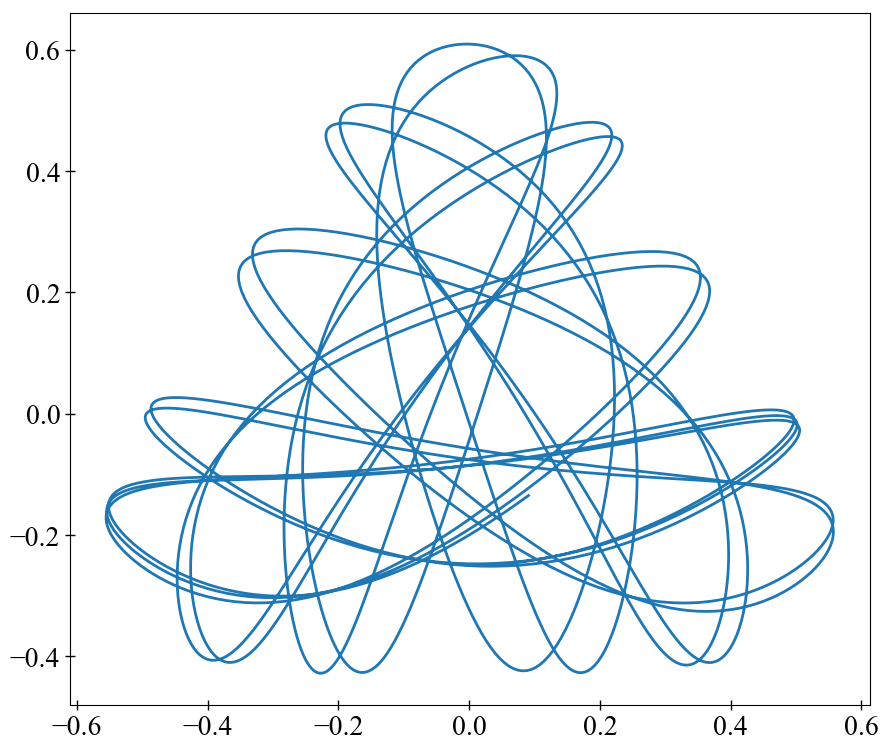

In [9]:
# Henon-heiles famous system
# Clearly, since the system is only 4-dimensional, we should use the
# out-of-place equations of motion, that return an `SVector`.
# But this is only an example!
function hheom!(du, u, p, t)
    du[1] = u[3]
    du[2] = u[4]
    du[3] = -u[1] - 2u[1]*u[2]
    du[4] = -u[2] - (u[1]^2 - u[2]^2)
    return nothing
end

# pass `nothing` as the parameters, because the system doesn't have any
hh = ContinuousDynamicalSystem(hheom!, [0, -0.25, 0.42081, 0], nothing)

# Evolve the system using DifferentialEquations.jl
tr = trajectory(hh, 100.0, dt = 0.05)

plot(tr[:, 1], tr[:, 2]);

# Time-evolution of systems & DifferentialEquations.jl
Discrete systems are evolved using internal "solvers". However, all time evolution of continuous systems is done through the [DifferentialEquations.jl](http://docs.juliadiffeq.org/latest/) library. In fact, `trajectory` for continuous systems simply wraps `solve` with some extra arguments.

Keep in mind that by default all continuous systems are evolved using the solver `Vern9()` (9th order Verner solver) with tolerances `abstol = reltol = 1e-9`. This is especially important when one wants to compare benchmarks with different packages.

## When to use **DynamicalSystems.jl**?
If the *only* thing you care about is evolving a system in time, then you are probably better of using directly DifferentialEquations.jl. You can still do this *after* you have defined a dynamical system, because the field `prob` gives an `ODEProblem`:


In [10]:
hh.prob

DiffEqBase.ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, Inf)
u0: [0.0, -0.25, 0.42081, 0.0]

**(please be careful when using this problem directly, because as you can see the `tspan[end]` field is `Inf`!)**

**DynamicalSystems.jl** is useful when one wants to calculate quantities useful in nonlinear dynamics and chaos, like all the examples that we will show in the tutorials "Orbit diagrams, Surfaces of Section" and "Quantifying Chaos for a Dynamical System".

In addition, we offer specialized integrators that evolve the system and the tangent space, or many states of the system in parallel:
* `tangent_integrator`
* `parallel_integrator`

(more on these integrators in the tutorial "Advanced Usage")

These functions work for both continuous and discrete systems and also work regardless of if the system is in-place (large), out-of-place (small) or auto-differentiated. Special attention has also been given to the performance of the integrators. 

Also, keep in mind that regardless of if you use a `DynamicalSystem` to produce a timeseries or not, more than half of the **DynamicalSystems.jl** library is using numerical data as an input, which most of the time is expected in the form of some `AbstractDataset`, which is what `trajectory` returns.

In [1]:
?DynamicalSystem

search:

Couldn't find DynamicalSystem
Perhaps you meant DataType


No documentation found.

Binding `DynamicalSystem` does not exist.


In [9]:
?trajectory

search: trajectory



```
trajectory(ds::DynamicalSystem, T [, u]; kwargs...) -> dataset
```

Return a dataset that will contain the trajectory of the sytem, after evolving it for total time `T`, optionally starting from state `u`. See [`Dataset`](@ref) for info on how to use this object.

A `W×D` dataset is returned, with `W = length(t0:dt:T)` with `t0:dt:T` representing the time vector (*not* returned) and `D` the system dimension. For discrete systems both `T` and `dt` must be integers.

## Keyword Arguments

  * `dt` :  Time step of value output during the solving of the continuous system. For discrete systems it must be an integer. Defaults to `0.01` for continuous and `1` for discrete.
  * `diff_eq_kwargs` : (only for continuous) A dictionary `Dict{Symbol, ANY}` of keyword arguments passed into the solvers of the [DifferentialEquations.jl](http://docs.juliadiffeq.org/latest/basics/common_solver_opts.html) package, for example `Dict(:abstol => 1e-9)`. If you want to specify a solver, do so by using the symbol `:solver`, e.g.: `Dict(:solver => DP5(), :maxiters => 1e9)`. This requires you to have been first `using OrdinaryDiffEq` to access the solvers. Defaults to `Dict(:solver => Vern9(), :abstol => 1e-9, :reltol => 1e-9)`, i.e. a 9th order Verner algorithm.
